In [30]:
import pandas as pd

df = pd.read_csv('bank-full.csv', sep=';')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [31]:
df.drop('day', axis=1, inplace=True)

In [32]:
# split data into x_train, x_test, y_train, y_test with ratio of 70:30

x = df.drop('y', axis=1)
y = df['y']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=26)

In [33]:
# encode y to 0 and 1

from sklearn.preprocessing import LabelEncoder
import pandas as pd

le = LabelEncoder()
y_train = pd.Series(le.fit_transform(y_train), index=y_train.index, name='y')
y_test = pd.Series(le.transform(y_test), index=y_test.index, name='y')

# Show all unique values
print(y_train.unique())
print(y_test.unique())

y_train

[0 1]
[0 1]


,y
17283,0
9318,0
21761,0
4388,0
41476,0
...,...
23629,0
24275,1
10177,0
42416,0


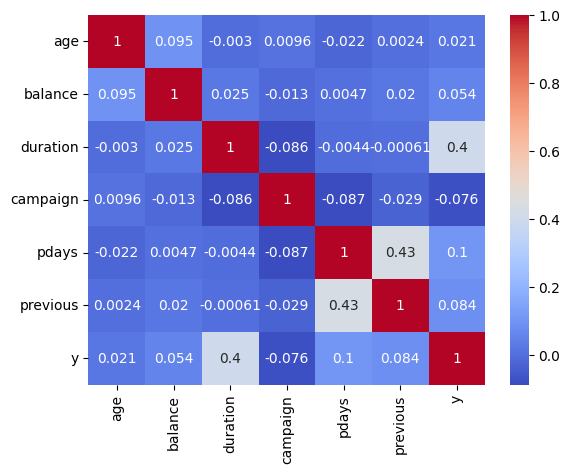

In [34]:
# get df_train by combining x_train and y_train

df_train = pd.concat([x_train, y_train], axis=1)

# get numerical (non object) columns of df

numerical_columns = df_train.select_dtypes(exclude='object').columns

# correlation heatmap

import seaborn as sns
import matplotlib.pyplot as plt

corr = df_train[numerical_columns].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [35]:
corr = df_train[numerical_columns].corr()
corr_with_y = corr['y'].sort_values(ascending=False)
print(corr_with_y)

y           1.000000
duration    0.398285
pdays       0.104684
previous    0.083787
balance     0.053779
age         0.020749
campaign   -0.075657
Name: y, dtype: float64


In [36]:
# define pipeline for preprocessors for numerical and categorical

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# numerical transformer pipeline

numeric_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# categorical transformer pipeline

categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# combine the transformers into a pipeline called preprocessor

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [37]:
# create a pipeline for decision tree

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import make_scorer, f1_score

# model_1 = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', DecisionTreeClassifier())
# ])

model_1 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                                          max_features=None, splitter='best'))
])

# use grid search to search for the best hyperparameters of the classifier

from sklearn.model_selection import GridSearchCV

# create sample of param_grid for DecisionTreeClassifier()

param_grid = {
    'classifier__max_depth': [10],
    # 'classifier__min_samples_split': [2, 5, 10],
    # 'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini'],
    'classifier__splitter': ['best'],
    'classifier__class_weight': [None],
    'classifier__max_features': [None],
    # 'classifier__min_impurity_decrease': [0.0, 0.1, 0.2],
    # 'classifier__min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    # 'classifier__max_leaf_nodes': [None, 10, 20, 30],
    # 'classifier__ccp_alpha': [0.0, 0.1, 0.2],
}

# scorer = make_scorer(f1_score, average='macro')
grid_search = GridSearchCV(model_1, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(x_train, y_train)

# review the best parameters

print(f"parameters:\n{grid_search.best_params_}")

# review the best score

print(f"f1-score (macro avg):\n{grid_search.best_score_}")

# train the model

model_1.fit(x_train, y_train)

# predict the model

y_pred = model_1.predict(x_test)

# review the classificiation report

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

parameters:
{'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__splitter': 'best'}
f1-score (macro avg):
0.7158765592105778
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     11955
           1       0.59      0.42      0.49      1609

    accuracy                           0.90     13564
   macro avg       0.76      0.69      0.72     13564
weighted avg       0.89      0.90      0.89     13564



In [38]:
# create a random forest pipeline model

from sklearn.ensemble import RandomForestClassifier

# model_2 = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', RandomForestClassifier())
# ])

model_2 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                          criterion='gini', max_depth=10, max_features='log2',
                                          n_estimators=200, random_state=66))
])

# create a sample param_grid for grid search of random forest classifier

param_grid = {
    'classifier__n_estimators': [200],
    'classifier__max_depth': [10],
    'classifier__criterion': ['gini'],
    'classifier__max_features': ['log2'],
    'classifier__class_weight': ['balanced'],
    'classifier__bootstrap': [True],

    # this yields inconsistent score
    # the highest I got was 0.735581042845531 (unknown random_state)
    'classifier__random_state': [66]
}

# implement grid search

grid_search = GridSearchCV(model_2, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(x_train, y_train)

# review the best parameters

print(f"parameters:\n{grid_search.best_params_}")

# review the best score

print(f"f1-score (macro avg):\n{grid_search.best_score_}")

# train the model

model_2.fit(x_train, y_train)

# evaluate classification report

from sklearn.metrics import classification_report

y_pred = model_2.predict(x_test)

print(classification_report(y_test, y_pred))

parameters:
{'classifier__bootstrap': True, 'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__n_estimators': 200, 'classifier__random_state': 66}
f1-score (macro avg):
0.7289471990347038
              precision    recall  f1-score   support

           0       0.98      0.84      0.91     11955
           1       0.42      0.84      0.56      1609

    accuracy                           0.84     13564
   macro avg       0.70      0.84      0.73     13564
weighted avg       0.91      0.84      0.86     13564



In [39]:
# create an adaboost model with pipeline

from sklearn.ensemble import AdaBoostClassifier

# model_3 = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', AdaBoostClassifier())
# ])

model_3 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(learning_rate=1.75, n_estimators=100, random_state=26))
])

# create a sample param_grid for grid search of adaboost

param_grid = {
    'classifier__n_estimators': [100],
    'classifier__learning_rate': [1.75],

    # this yields inconsistent score
    'classifier__random_state': [26]
}

# implement grid search

grid_search = GridSearchCV(model_3, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(x_train, y_train)

# review the best parameters

print(f"parameters:\n{grid_search.best_params_}")

# review the best score

print(f"f1-score (macro avg):\n{grid_search.best_score_}")

# train the model

model_3.fit(x_train, y_train)

# evaluate classification report

from sklearn.metrics import classification_report

y_pred = model_3.predict(x_test)

print(classification_report(y_test, y_pred))

parameters:
{'classifier__learning_rate': 1.75, 'classifier__n_estimators': 100, 'classifier__random_state': 26}
f1-score (macro avg):
0.7067367678225387
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     11955
           1       0.61      0.37      0.46      1609

    accuracy                           0.90     13564
   macro avg       0.77      0.67      0.70     13564
weighted avg       0.88      0.90      0.89     13564



In [40]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Load dataset
# df = pd.read_csv("your_data.csv")
X = df.drop(columns=['y'])  # Features
y = df['y']  # Target variable

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Split data into train and test sets (30% test data, random_state=26)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26, stratify=y)

# Define a column transformer to apply OneHotEncoder & StandardScaler
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
])

# Apply transformations
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Get feature names after OneHotEncoding
feature_names = preprocessor.get_feature_names_out()

# Convert to DataFrame
X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)

# Define base estimator for RFECV
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFECV to find the best subset of features
rfecv = RFECV(
    estimator=rf,
    step=1,
    cv=StratifiedKFold(n_splits=5),
    scoring='f1_macro',  # Optimize for macro-average F1 score
    n_jobs=-1
)

X_train_selected = rfecv.fit_transform(X_train_transformed, y_train)
X_test_selected = rfecv.transform(X_test_transformed)

# Convert back to DataFrame
selected_features = feature_names[rfecv.support_]
X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features)

In [43]:
# Define base learners for stacking
base_learners_1 = [
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('ab', AdaBoostClassifier(n_estimators=50, random_state=42))
]

base_learners_2 = [
    ('dt', model_1),
    ('rf', model_2),
    ('ab', model_3)
]

# Define stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_learners_1,
    final_estimator=LogisticRegression(),
    cv=5,  # Cross-validation for stacking
    n_jobs=-1
)

# Define stacking classifier
model_4 = StackingClassifier(
    estimators=base_learners_2,
    final_estimator=LogisticRegression(),
    cv=5,  # Cross-validation for stacking
    n_jobs=-1
)

# Train the stacking classifier on the reduced feature set
stacking_clf.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = stacking_clf.predict(X_test_selected)

# Evaluate model performance
print("Classification Report on Test Data:")
print(classification_report(y_test, y_pred))

Classification Report on Test Data:
              precision    recall  f1-score   support

          no       0.93      0.97      0.95     11977
         yes       0.65      0.46      0.54      1587

    accuracy                           0.91     13564
   macro avg       0.79      0.71      0.74     13564
weighted avg       0.90      0.91      0.90     13564



In [44]:
model_4

StackingClassifier(cv=5,
                   estimators=[('dt',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(strategy='median')),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['age',
                                                                                   'balance',
                                                                                   'duration',
                                                                                   'campaign',
                                                                                   'pdays',
                                                                                   'previous']),
                                                                                 ('cat',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value='missing',
                                                                                                                 strategy='constan...
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value='missing',
                                                                                                                 strategy='constant')),
                                                                                                  ('onehot',
                                                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                                                  ['job',
                                                                                   'marital',
                                                                                   'education',
                                                                                   'default',
                                                                                   'housing',
                                                                                   'loan',
                                                                                   'contact',
                                                                                   'month',
                                                                                   'poutcome'])])),
                                                ('classifier',
                                                 AdaBoostClassifier(learning_rate=1.75,
                                                                    n_estimators=100,
                                                                    random_state=26))]))],
                   final_estimator=LogisticRegression(), n_jobs=-1)